In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pcmdpy_gpu as ppy
import pandas as pd
from astropy.io import fits
from scipy.misc import face
from scipy.signal import gaussian
from scipy.stats import norm as normal
from tqdm import tqdm
import seaborn.apionly as sns
plt.style.use('seaborn-poster')
mpl.rcParams['image.origin'] = 'lower'
%matplotlib inline

In [2]:
mpl.rcParams['image.aspect'] = 'auto'
mpl.rcParams['image.interpolation'] = 'None'

In [3]:
f_m31 = ppy.instrument.default_m31_filters()
f_m49 = ppy.instrument.default_m49_filters()

In [4]:
# for f_ in f_m49:
#     f_._exposure *= 2.

In [5]:
iso_m31 = ppy.isochrones.Isochrone_Model(f_m31)
iso_m49 = ppy.isochrones.Isochrone_Model(f_m49)

In [6]:
driv_m31 = ppy.driver.Driver(iso_m31)
driv_m49 = ppy.driver.Driver(iso_m49)

In [7]:
res = ppy.results.ResultsPlotter('results/m31_taulm3_narrowF814W_r1.csv', run_name='m31_bulge')
# m31_params = res.df.tail(1)[['logfeh_mean', 'logdust', 'logNpix', 'tau', 'dmod']].values[0]
m31_params = np.array([0., -2., 2.3, 1.0, 24.42])
m31_params

array([ 0.  , -2.  ,  2.3 ,  1.  , 24.42])

In [8]:
gal_m31 = ppy.galaxy.TauFull(m31_params)
gal_m49 = ppy.galaxy.TauFull(np.array([0., -2., 5.2, 1.0, 31.3]))

In [9]:
%%time
driv_m31.filters = ppy.instrument.default_m31_filters()
driv_m49.filters = ppy.instrument.default_m49_filters()

sim_m31 = driv_m31.simulate(gal_m31, 1024, mag_system='ab')[1]
sim_m49 = driv_m49.simulate(gal_m49, 1024)[1]

CPU times: user 12 s, sys: 4.34 s, total: 16.4 s
Wall time: 19.1 s


In [10]:
%%time
driv_m31.filters = ppy.instrument.m31_narrow_psf(alpha_F475W=1.234, alpha_F814W=1.234)
sim_m31_narrow = driv_m31.simulate(gal_m31, 1024, mag_system='ab')[1]

CPU times: user 6.02 s, sys: 2.04 s, total: 8.07 s
Wall time: 8.72 s


In [87]:
def spatial_correlation(im, a=3):
    im /= im.sum()
#     im -= im.min()
#     im /= im.max()
#     im /= (im.shape[0] * im.shape[1])
    nx, ny = im.shape
    im_p = np.fft.fft2(im)
    corr = np.fft.ifft2(im_p * np.conjugate(im_p)).real
    corr /= (corr.shape[0] * corr.shape[1])
#     corr -= corr.min()
#     corr /= corr.max()
#     corr /= corr.mean()
#     corr -= 1.
    corr = np.roll(np.roll(corr, ny//2, axis=-1), nx//2, axis=-2)
    corr = corr[(nx//2)-a:(nx//2)+a+1,(ny//2)-a:(ny//2)+a+1]
    Y = np.arange(-a, a+1).repeat(2*a + 1).reshape((2*a+1, 2*a+1))
    X = Y.T
    R = np.sqrt(X**2 + Y**2)
    sort_idx = R.flatten().argsort()
    r = R.flatten()[sort_idx]
    c = corr.flatten()[sort_idx]
    return corr, r, c

In [88]:
def show_corr(corr_im, ax=None, norm=None):
    if ax is None:
        fig, ax = plt.subplots()
    if norm is None:
        norm = mpl.colors.Normalize()
    ax.imshow(corr_im, interpolation='None', aspect='auto', norm=norm)
    return ax

In [89]:
m31 = fits.open('../data/m31/raw/bulge_tiny_both.fits')
m49_raw = fits.open('../data/m49/raw/oneexp_tiny_both.fits')
m49_drz = fits.open('../data/m49/raw/drizzled_tiny_both.fits')

In [90]:
m31_f475w = m31['sci,1'].data * 3620.
m31_f814w = m31['sci,2'].data * 3235.

In [91]:
m31_f475w

array([[2568.975 , 3108.1255, 2180.223 , ..., 1468.3766, 1395.2751,
        1224.3689],
       [2717.3286, 3560.9763, 2353.4214, ..., 1730.5009, 1589.9176,
        1508.3096],
       [2029.5929, 2425.6152, 2073.1997, ..., 2093.0547, 1745.7484,
        1585.6926],
       ...,
       [1562.3881, 1382.2102, 1214.7983, ..., 1289.4509, 1324.5009,
        1310.3077],
       [1249.8367, 1126.7859, 1101.7345, ..., 1412.2369, 1583.9524,
        1566.488 ],
       [1217.9065, 1029.0016, 1065.8903, ..., 1499.6365, 1813.798 ,
        1873.8097]], dtype=float32)

Text(0.5,1,'Simulated')

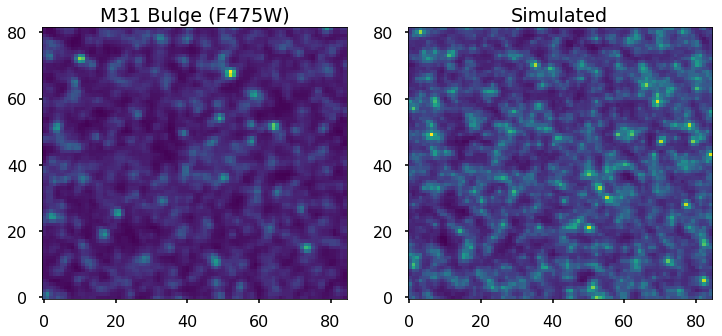

In [92]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5))
axes[0].imshow(m31_f475w)
axes[1].imshow(sim_m31[1][:m31_f475w.shape[0], :m31_f475w.shape[1]])
axes[0].set_title('M31 Bulge (F475W)')
axes[1].set_title('Simulated')

In [93]:
m49_f475w_raw = m49_raw['sci,1'].data
m49_f850lp_raw = m49_raw['sci,2'].data
m49_f475w_raw[np.isnan(m49_f475w_raw)] = -1.
m49_f850lp_raw[np.isnan(m49_f850lp_raw)] = -1.

In [94]:
m49_f475w_drz = m49_drz['sci,1'].data * f_m49[1]._exposure
m49_f850lp_drz = m49_drz['sci,2'].data * f_m49[0]._exposure

Text(0.5,1,'Simulated')

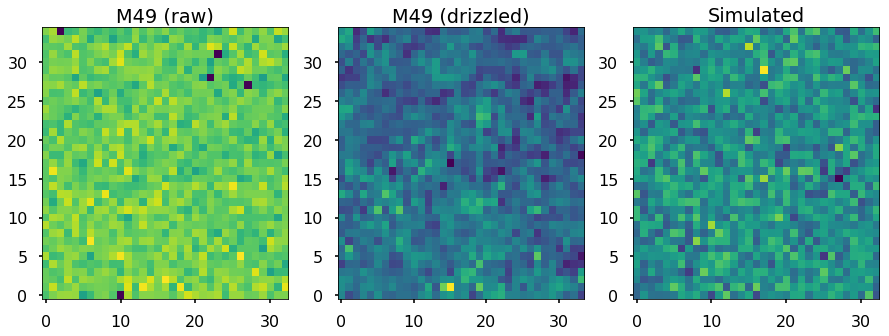

In [95]:
fig, axes = plt.subplots(ncols=3, figsize=(15,5))
axes[0].imshow(m49_f475w_raw)
axes[1].imshow(m49_f475w_drz)
axes[2].imshow(sim_m49[1][:m49_f475w_raw.shape[0], :m49_f475w_raw.shape[1]])
axes[0].set_title('M49 (raw)')
axes[1].set_title('M49 (drizzled)')
axes[2].set_title('Simulated')

In [96]:
corrs, xs, ys = {}, {}, {}

In [97]:
ims = {
    'm31_f475w_drz': m31_f475w,
    'm31_f814w_drz': m31_f814w,
    'm31_f475w_sim': sim_m31[1],
    'm31_f814w_sim': sim_m31[0],
    'm31_f475w_sim_narrow': sim_m31_narrow[1],
    'm31_f814w_sim_narrow': sim_m31_narrow[0],
    'm49_f475w_raw': m49_f475w_raw,
    'm49_f475w_drz': m49_f475w_drz,
    'm49_f475w_sim': sim_m49[1],
    'm49_f850lp_raw': m49_f850lp_raw,
    'm49_f850lp_drz': m49_f850lp_drz,
    'm49_f850lp_sim': sim_m49[0],
}

In [98]:
for name, im in ims.items():
#     im /= im.mean()
    corrs[name], xs[name], ys[name] = spatial_correlation(im, a=5)

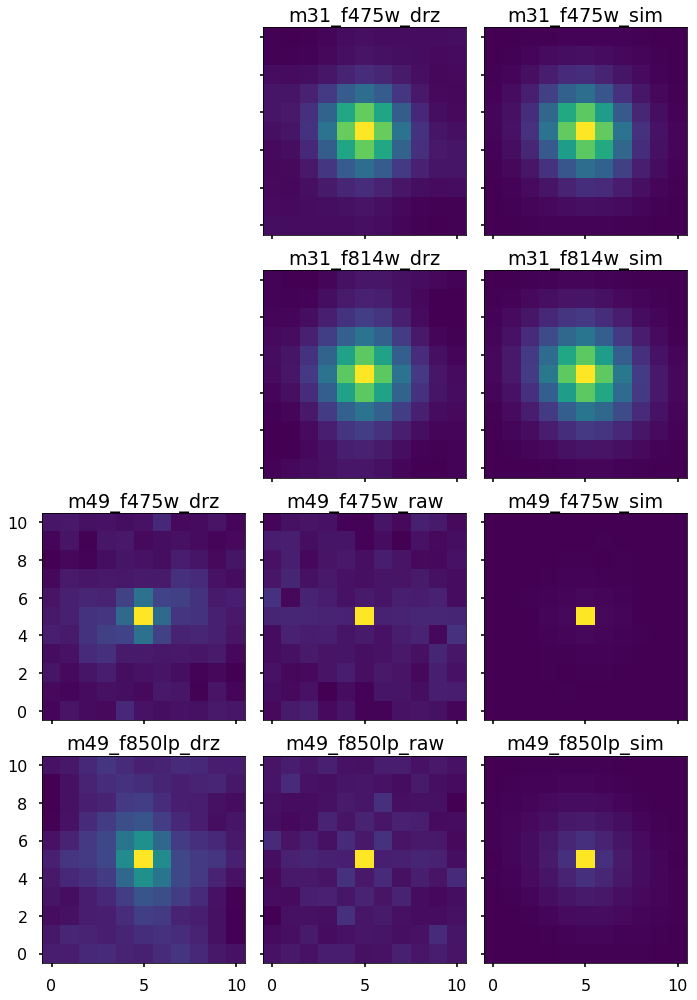

In [99]:
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(10, 14), sharex=True, sharey=True)
for a, n in zip(axes[0][1:], ['m31_f475w_drz', 'm31_f475w_sim']):
    norm = mpl.colors.Normalize()
    show_corr(corrs[n], ax=a, norm=norm)
    a.set_title(n)
axes[0,0].axis('off')

for a, n in zip(axes[1][1:], ['m31_f814w_drz', 'm31_f814w_sim']):
    norm = mpl.colors.Normalize()
    show_corr(corrs[n], ax=a, norm=norm)
    a.set_title(n)
axes[1,0].axis('off')

for a, n in zip(axes[2], ['m49_f475w_drz', 'm49_f475w_raw', 'm49_f475w_sim']):
    norm = mpl.colors.Normalize()
    show_corr(corrs[n], ax=a, norm=norm)
    a.set_title(n)

for a, n in zip(axes[3], ['m49_f850lp_drz', 'm49_f850lp_raw', 'm49_f850lp_sim']):
    norm = mpl.colors.Normalize()
    show_corr(corrs[n], ax=a, norm=norm)
    a.set_title(n)

plt.tight_layout()

In [100]:
palette = sns.color_palette('colorblind')

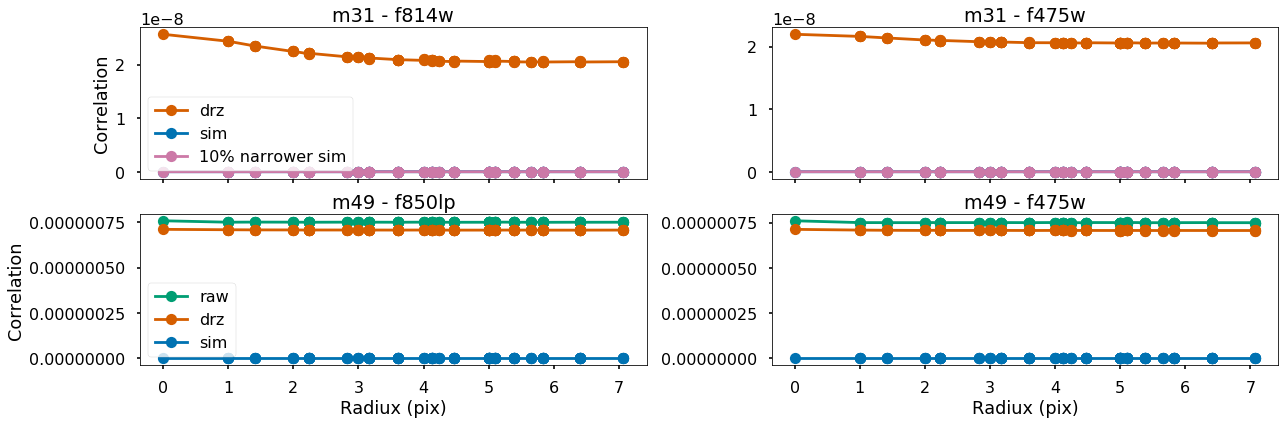

In [101]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18, 6), sharex=True)
for n in xs.keys():
    if 'm31' in n:
        if 'f814w' in n:
            ax = axes[0,0]
        else:
            ax = axes[0,1]
    else:
        if 'f850lp' in n:
            ax = axes[1,0]
        else:
            ax = axes[1,1]
    if 'narrow' in n:
        label='10% narrower sim'
        color = palette[3]
    elif 'sim' in n:
        label = 'sim'
        color= palette[0]
    elif 'raw' in n:
        label = 'raw'
        color = palette[1]
    else:
        label = 'drz'
        color = palette[2]
    ax.plot(xs[n], ys[n], label=label, color=color, ls='-', marker='o')
axes[0,0].set_title('m31 - f814w')
axes[0,1].set_title('m31 - f475w')
axes[1,0].set_title('m49 - f850lp')
axes[1,1].set_title('m49 - f475w')
axes[1,0].legend(loc=0)
axes[0,0].legend(loc=0)
for a in axes[1]:
    a.set_xlabel('Radiux (pix)')
for a in axes[:,0]:
    a.set_ylabel('Correlation')
# for a in axes.flatten():
#     a.set_xscale('log')
#     a.set_xlim(xmax=4)
#     a.set_yscale('log')
#     a.set_ylim([0.001, 1])
plt.tight_layout()

In [103]:
np.sqrt(ys['m31_f814w_drz']/ys['m31_f814w_sim'])

array([135.54510451, 138.20134683, 138.06285861, 138.06285861,
       138.20134683, 140.76429941, 139.55411215, 139.55411215,
       140.76429941, 142.61009303, 142.3269175 , 142.61009303,
       142.3269175 , 144.11151549, 144.25194422, 144.11151549,
       142.95631431, 144.25194422, 142.95631431, 142.74316281,
       142.74316281, 144.57499756, 144.57499756, 146.23804328,
       146.23804328, 145.91141678, 146.58847957, 146.58847957,
       145.91141678, 146.39570624, 146.76876318, 146.76876318,
       147.32706689, 146.39570624, 147.32706689, 145.82341687,
       145.82341687, 146.83242789, 147.75822549, 148.09990206,
       147.75822549, 146.56141097, 146.56141097, 148.09990206,
       146.83242789, 147.9709879 , 147.9709879 , 149.02448903,
       149.02448903, 148.28864634, 149.29638556, 147.87525127,
       148.71474646, 147.87525127, 149.29638556, 148.28864634,
       148.71474646, 148.63021697, 147.73665402, 147.73665402,
       148.63021697, 148.6085652 , 149.3552681 , 148.53

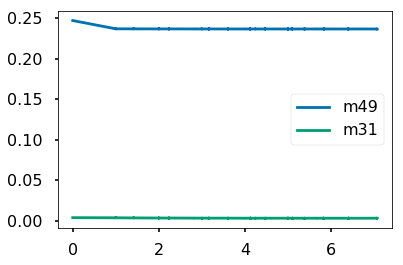

In [85]:
plt.plot(xs['m49_f475w_sim'], ys['m49_f475w_sim'], label='m49')
plt.plot(xs['m31_f475w_sim'], ys['m31_f475w_sim'], label='m31')
plt.legend(loc=0)
# plt.xscale('log')
# plt.yscale('log')

# Experiment with Image Params

In [63]:
g1 = ppy.galaxy.TauFull(np.array([0., -2., 2., 1.0, 30.]))
g2 = ppy.galaxy.TauFull(np.array([0., -2., 4., 1.0, 30.]))
g3 = ppy.galaxy.TauFull(np.array([0., -2., 2., 1.0, 20.]))
g4 = ppy.galaxy.TauFull(np.array([0., -2., 2., 5.0, 30.]))

In [64]:
driv_m31.filters = ppy.instrument.default_m31_filters()
im1 = driv_m31.simulate(g1, 1024)[1][0]
im2 = driv_m31.simulate(g2, 1024)[1][0]
im3 = driv_m31.simulate(g3, 1024)[1][0]
im4 = driv_m31.simulate(g4, 1024)[1][0]

alpha = 1.5
driv_m31.filters = ppy.instrument.m31_narrow_psf(alpha_F475W=1.5, alpha_F814W=1.5)
sig = 100.*(1.-(1./np.sqrt(alpha)))
im5 = driv_m31.simulate(g1, 1024)[1][0]

In [31]:
a = 50
_, x1, y1 = spatial_correlation(im1, a=a)
_, x2, y2 = spatial_correlation(im2, a=a)
_, x3, y3 = spatial_correlation(im3, a=a)
_, x4, y4 = spatial_correlation(im4, a=a)
_, x5, y5 = spatial_correlation(im5, a=a)

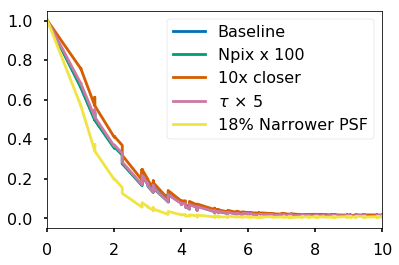

In [32]:
sns.set_palette('colorblind')
plt.plot(x1, y1, label='Baseline')
plt.plot(x2, y2, label='Npix x 100')
plt.plot(x3, y3, label='10x closer')
plt.plot(x4, y4, label=r'$\tau\,\times\,5$')
plt.plot(x5, y5, label='{:.0f}% Narrower PSF'.format(sig))
# plt.yscale('log')
plt.xlim([0, 10])
plt.legend(loc=0)

# Find decent PSF match

In [33]:
def narrow_f814w(alpha):
    psf = ppy.instrument.psf.PSF_Model.from_fits('ACS_WFC_F814W', narrow_alpha=alpha)
    return ppy.instrument.ACS_WFC_F814W(exposure=3235., psf=psf)

In [34]:
def narrow_f475w(alpha):
    psf = ppy.instrument.psf.PSF_Model.from_fits('ACS_WFC_F475W', narrow_alpha=alpha)
    return ppy.instrument.ACS_WFC_F475W(exposure=3620., psf=psf)

In [35]:
%%time
driv_m31.filters = ppy.instrument.default_m31_filters()
im_nopsf = driv_m31.simulate(gal_m31, 1024, mag_system='ab', psf=False)[1]

CPU times: user 5.43 s, sys: 1.97 s, total: 7.4 s
Wall time: 8.14 s


In [36]:
def corr_narrow(alpha, Nim=1024):
    filts = [narrow_f814w(alpha), narrow_f475w(alpha)]
    im_test = [f_.psf_convolve(im, dither=True) for f_,im in zip(filts, im_nopsf)]
    corr, x1, y1 = spatial_correlation(im_test[0], a=5)
    corr, x2, y2 = spatial_correlation(im_test[1], a=5)
    return x1, y1, x2, y2

In [37]:
xs_f475w, ys_f475w = {}, {}
xs_f814w, ys_f814w = {}, {}

for alpha in tqdm(np.arange(0.8, 2., 0.01)):
    a = np.round(alpha, 3)
    xs_f814w[a], ys_f814w[a], xs_f475w[a], ys_f475w[a] = corr_narrow(alpha, Nim=1024)

100%|██████████| 120/120 [02:11<00:00,  1.09s/it]


In [38]:
k = list(xs_f814w.keys())
s = np.round(100.*(1.-(1./np.sqrt(k))), 2)
sigs = dict(zip(s, k))
sigs_arr = np.array(list(sigs.keys()))
sigs_arr

array([-11.8 , -11.11, -10.43,  -9.76,  -9.11,  -8.47,  -7.83,  -7.21,
        -6.6 ,  -6.  ,  -5.41,  -4.83,  -4.26,  -3.7 ,  -3.14,  -2.6 ,
        -2.06,  -1.53,  -1.02,  -0.5 ,   0.  ,   0.5 ,   0.99,   1.47,
         1.94,   2.41,   2.87,   3.33,   3.77,   4.22,   4.65,   5.08,
         5.51,   5.93,   6.34,   6.75,   7.15,   7.55,   7.94,   8.33,
         8.71,   9.09,   9.46,   9.83,  10.2 ,  10.56,  10.91,  11.26,
        11.61,  11.95,  12.29,  12.63,  12.96,  13.29,  13.61,  13.93,
        14.25,  14.56,  14.87,  15.18,  15.48,  15.78,  16.08,  16.38,
        16.67,  16.95,  17.24,  17.52,  17.8 ,  18.08,  18.35,  18.62,
        18.89,  19.15,  19.42,  19.68,  19.94,  20.19,  20.44,  20.69,
        20.94,  21.19,  21.43,  21.67,  21.91,  22.15,  22.38,  22.62,
        22.85,  23.08,  23.3 ,  23.53,  23.75,  23.97,  24.19,  24.41,
        24.62,  24.84,  25.05,  25.26,  25.46,  25.67,  25.88,  26.08,
        26.28,  26.48,  26.68,  26.87,  27.07,  27.26,  27.45,  27.64,
      

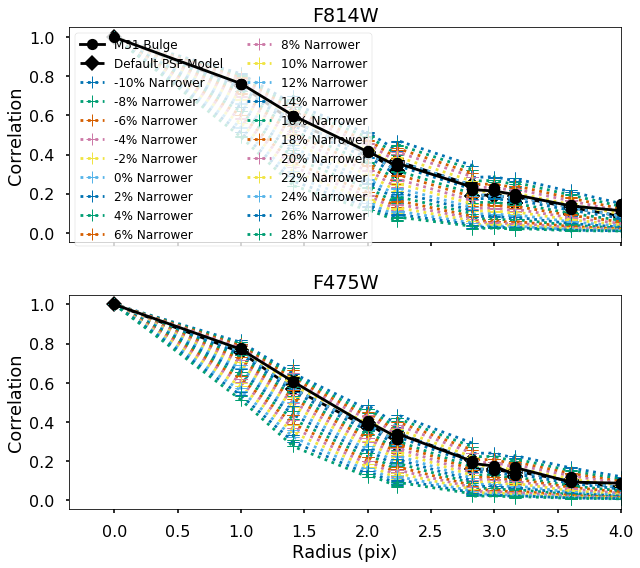

In [39]:
fig, axes = plt.subplots(nrows=2, figsize=(9, 8), sharex=True)
axes[0].plot(xs['m31_f814w_drz'], ys['m31_f814w_drz'], label='M31 Bulge', marker='o', color='k', zorder=10)
axes[1].plot(xs['m31_f475w_drz'], ys['m31_f475w_drz'], label='M31 Bulge', marker='o', color='k', zorder=10)

axes[0].plot(xs_f814w[1.00], ys_f814w[1.00], label='Default PSF Model', marker='D', ls='--', color='k')
axes[1].plot(xs_f475w[1.00], ys_f475w[1.00], label='Default PSF Model', marker='D', ls='--', color='k')

for s in np.arange(-10, 30, 2):
    d_sig = sigs_arr[np.abs(s - sigs_arr).argmin()]
    k = sigs[d_sig]
    axes[0].plot(xs_f814w[k], ys_f814w[k], label='{:.0f}% Narrower'.format(d_sig), marker='+', ls=':', mew=1)
    axes[1].plot(xs_f475w[k], ys_f475w[k], label='{:.0f}% Narrower'.format(d_sig), marker='+', ls=':', mew=1)
axes[0].set_title('F814W')
axes[1].set_title('F475W')
axes[0].legend(loc=0, ncol=2, fontsize=12)
axes[0].set_xlim(xmax=4)

for a in axes:
    a.set_ylabel('Correlation')
axes[1].set_xlabel('Radius (pix)')
plt.tight_layout()

In [40]:
def group(x, y, xmax=2.0):
    x_, y_, y_err = [], [], []
    for i in sorted(np.unique(x)):
        if i > xmax:
            break
        x_.append(i)
        ys = y[x == i]
        y_.append(np.mean(ys))
        y_err.append(np.std(ys))
    return np.array(x_), np.array(y_), np.array(y_err)

In [41]:
def loglike(x1, y1, x2, y2):
    x1, y1, yerr1 = group(x1, y1)
    x2, y2, yerr2 = group(x2, y2)
    assert np.all(x1 == x2)
    return normal.logpdf(y2, loc=y1, scale=np.sqrt(yerr1**2 + yerr2**2)).sum()

In [42]:
ll_f475w, ll_f814w = {}, {}
for k in xs_f475w.keys():
    ll_f475w[k] = loglike(xs['m31_f475w_drz'], ys['m31_f475w_drz'], xs_f475w[k], ys_f475w[k])
    ll_f814w[k] = loglike(xs['m31_f814w_drz'], ys['m31_f814w_drz'], xs_f814w[k], ys_f814w[k])

/n/home01/bcook/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1694: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/n/home01/bcook/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/n/home01/bcook/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


In [43]:
def alpha_to_percent(alpha):
    return 100.*(1. - (1./np.sqrt(alpha)))

In [44]:
ll_f475w = pd.DataFrame(data=list(ll_f475w.values()), index=np.round(list(ll_f475w.keys()), 3), columns=['ll_f475w'])
ll_f814w = pd.DataFrame(data=list(ll_f814w.values()), index=np.round(list(ll_f814w.keys()), 3), columns=['ll_f814w'])

In [45]:
ll_f475w['ll_f814w'] = ll_f814w.loc[ll_f475w.index]
ll_f475w['alpha'] = ll_f475w.index
ll_f475w['sig'] = alpha_to_percent(ll_f475w.index)

In [46]:
ll = ll_f475w.sort_index()
ll.head()

,ll_f475w,ll_f814w,alpha,sig
0.80,NaN,NaN,0.80,-11.803399
0.81,NaN,NaN,0.81,-11.111111
0.82,NaN,NaN,0.82,-10.431526
0.83,NaN,NaN,0.83,-9.764260
0.84,NaN,NaN,0.84,-9.108945


In [47]:
best_f475w = ll.loc[ll.ll_f475w.idxmax()]
best_f475w

TypeError: cannot use label indexing with a null key

In [ ]:
best_f814w = ll.loc[ll.ll_f814w.idxmax()]
best_f814w

In [ ]:
plt.plot(ll.sig, ll.ll_f814w-np.max(ll.ll_f814w), label='F814W')
plt.plot(ll.sig, ll.ll_f475w-np.max(ll.ll_f475w), label='F475W')
plt.legend(loc=0)
plt.ylim([-400, 50])

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(9, 8), sharex=True)
axes[0].plot(xs['m31_f814w_drz'], ys['m31_f814w_drz'], label='M31 Bulge', marker='o', ls='')
axes[1].plot(xs['m31_f475w_drz'], ys['m31_f475w_drz'], label='M31 Bulge', marker='o', ls='')
axes[0].plot(xs_f814w[best_f814w.alpha], ys_f814w[best_f814w.alpha], label='{:.1f}% Narrower'.format(best_f814w.sig), marker='+', ls='', mew=2)
axes[1].plot(xs_f475w[best_f475w.alpha], ys_f475w[best_f475w.alpha], label='{:.1f}% Narrower'.format(best_f475w.sig), marker='+', ls='', mew=2)
axes[0].plot(xs['m31_f814w_sim'], ys['m31_f814w_sim'], label='Baseline Model', marker='x', ls='', mew=2)
axes[1].plot(xs['m31_f475w_sim'], ys['m31_f475w_sim'], label='Baseline Model', marker='x', ls='', mew=2)
axes[0].set_title('F814W')
axes[1].set_title('F475W')
axes[0].legend(loc=0, ncol=3, fontsize=12)
axes[1].legend(loc=0, ncol=3, fontsize=12)
axes[0].set_xlim(xmax=4)
plt.tight_layout()